In [ ]:
from google.colab import files
files.upload()

Saving Test_jPKyvmK.csv to Test_jPKyvmK.csv
Saving Train_eP48B9k.csv to Train_eP48B9k.csv


{'Test_jPKyvmK.csv': b'id,customer_age,job_type,marital,education,default,balance,housing_loan,personal_loan,communication_type,day_of_month,month,last_contact_duration,num_contacts_in_campaign,days_since_prev_campaign_contact,num_contacts_prev_campaign,prev_campaign_outcome\nid_17231,55.0,retired,married,tertiary,no,7136.0,no,no,cellular,13,aug,90.0,2.0,,0,unknown\nid_34508,24.0,blue-collar,single,secondary,no,179.0,yes,no,cellular,18,may,63.0,2.0,,0,unknown\nid_44504,46.0,technician,divorced,secondary,no,143.0,no,no,cellular,8,jul,208.0,1.0,,0,unknown\nid_174,56.0,housemaid,single,unknown,no,6023.0,no,no,unknown,6,jun,34.0,1.0,,0,unknown\nid_2115,62.0,retired,married,secondary,no,2913.0,no,no,cellular,12,apr,127.0,1.0,188.0,1,success\nid_20153,35.0,self-employed,single,tertiary,no,355.0,no,no,cellular,12,aug,599.0,1.0,,0,unknown\nid_20552,27.0,housemaid,single,secondary,no,718.0,yes,no,unknown,8,may,94.0,3.0,,0,unknown\nid_26080,29.0,management,single,tertiary,no,54.0,yes,yes,unknown

In [ ]:
!pip install seaborn

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('seaborn-whitegrid')

import seaborn as sns
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.metrics import accuracy_score, f1_score

from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression

from lightgbm import LGBMClassifier

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

pd.set_option('display.max_colwidth', -1)

import warnings
warnings.simplefilter('ignore')

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:19: FutureWarning: Passing a negative integer is deprecated in version 1.0 and will not be supported in future version. Instead, use None to not limit the column width.


In [ ]:
train = pd.read_csv('Train_eP48B9k.csv')
test = pd.read_csv('Test_jPKyvmK.csv')

In [ ]:
train.head()
test.head()

id  customer_age  ... prev_campaign_outcome term_deposit_subscribed
0  id_43823  28.0          ...  unknown               0                     
1  id_32289  34.0          ...  other                 0                     
2  id_10523  46.0          ...  unknown               0                     
3  id_43951  34.0          ...  unknown               0                     
4  id_40992  41.0          ...  unknown               0                     

[5 rows x 18 columns]

id  customer_age  ... num_contacts_prev_campaign prev_campaign_outcome
0  id_17231  55.0          ...  0                          unknown             
1  id_34508  24.0          ...  0                          unknown             
2  id_44504  46.0          ...  0                          unknown             
3  id_174    56.0          ...  0                          unknown             
4  id_2115   62.0          ...  1                          success             

[5 rows x 17 columns]

In [ ]:
train.shape
test.shape

(31647, 18)

(13564, 17)

**Checking for imbalance**

In [ ]:
train['term_deposit_subscribed'].value_counts(normalize=True)

0    0.892754
1    0.107246
Name: term_deposit_subscribed, dtype: float64

Text(0.5, 1.0, 'Target distribution')

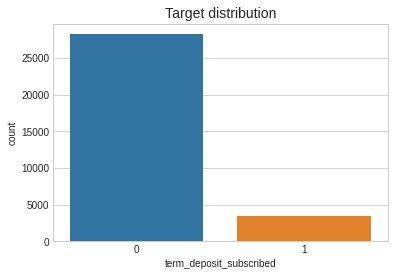

In [ ]:
sns.countplot(train['term_deposit_subscribed'])
plt.title('Target distribution', fontsize=14)

In [ ]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 31647 entries, 0 to 31646
Data columns (total 18 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   id                                31647 non-null  object 
 1   customer_age                      31028 non-null  float64
 2   job_type                          31647 non-null  object 
 3   marital                           31497 non-null  object 
 4   education                         31647 non-null  object 
 5   default                           31647 non-null  object 
 6   balance                           31248 non-null  float64
 7   housing_loan                      31647 non-null  object 
 8   personal_loan                     31498 non-null  object 
 9   communication_type                31647 non-null  object 
 10  day_of_month                      31647 non-null  int64  
 11  month                             31647 non-null  object 
 12  last

**Cheking for null values**

In [ ]:
null_values_per_variable = 100 * (train.isnull().sum()/train.shape[0]).round(3)#.reset_index()
null_values_per_variable.sort_values(ascending=False)

days_since_prev_campaign_contact    81.6
customer_age                        2.0 
balance                             1.3 
last_contact_duration               1.0 
personal_loan                       0.5 
marital                             0.5 
num_contacts_in_campaign            0.4 
job_type                            0.0 
education                           0.0 
default                             0.0 
term_deposit_subscribed             0.0 
housing_loan                        0.0 
prev_campaign_outcome               0.0 
communication_type                  0.0 
day_of_month                        0.0 
month                               0.0 
num_contacts_prev_campaign          0.0 
id                                  0.0 
dtype: float64

'days_since_prev_campaign_contact' has a lot of null values around 81.6 %, which might mean that these customers were never reached out in the previous campaign, there are few missing values in customer age, balance, last contact duration, personal loan, marital status & number of contacts in campaign

**Unique values in each variable**

In [ ]:
train.nunique()

id                                  31647
customer_age                        77   
job_type                            12   
marital                             3    
education                           4    
default                             2    
balance                             6563 
housing_loan                        2    
personal_loan                       2    
communication_type                  3    
day_of_month                        31   
month                               12   
last_contact_duration               1447 
num_contacts_in_campaign            46   
days_since_prev_campaign_contact    511  
num_contacts_prev_campaign          41   
prev_campaign_outcome               4    
term_deposit_subscribed             2    
dtype: int64

Segregating Categorical & Numerical Variables


In [ ]:
cat_cols = ['job_type',
 'marital',
 'education',
 'default',
 'housing_loan',
 'personal_loan',
 'communication_type',
 'month',
 'prev_campaign_outcome']

In [ ]:
num_cols = [c for c in train.columns if c not in cat_cols]
num_cols.remove('id')
num_cols.remove('term_deposit_subscribed')
num_cols

['customer_age',
 'balance',
 'day_of_month',
 'last_contact_duration',
 'num_contacts_in_campaign',
 'days_since_prev_campaign_contact',
 'num_contacts_prev_campaign']

**Categorical features: Univariate analysis**

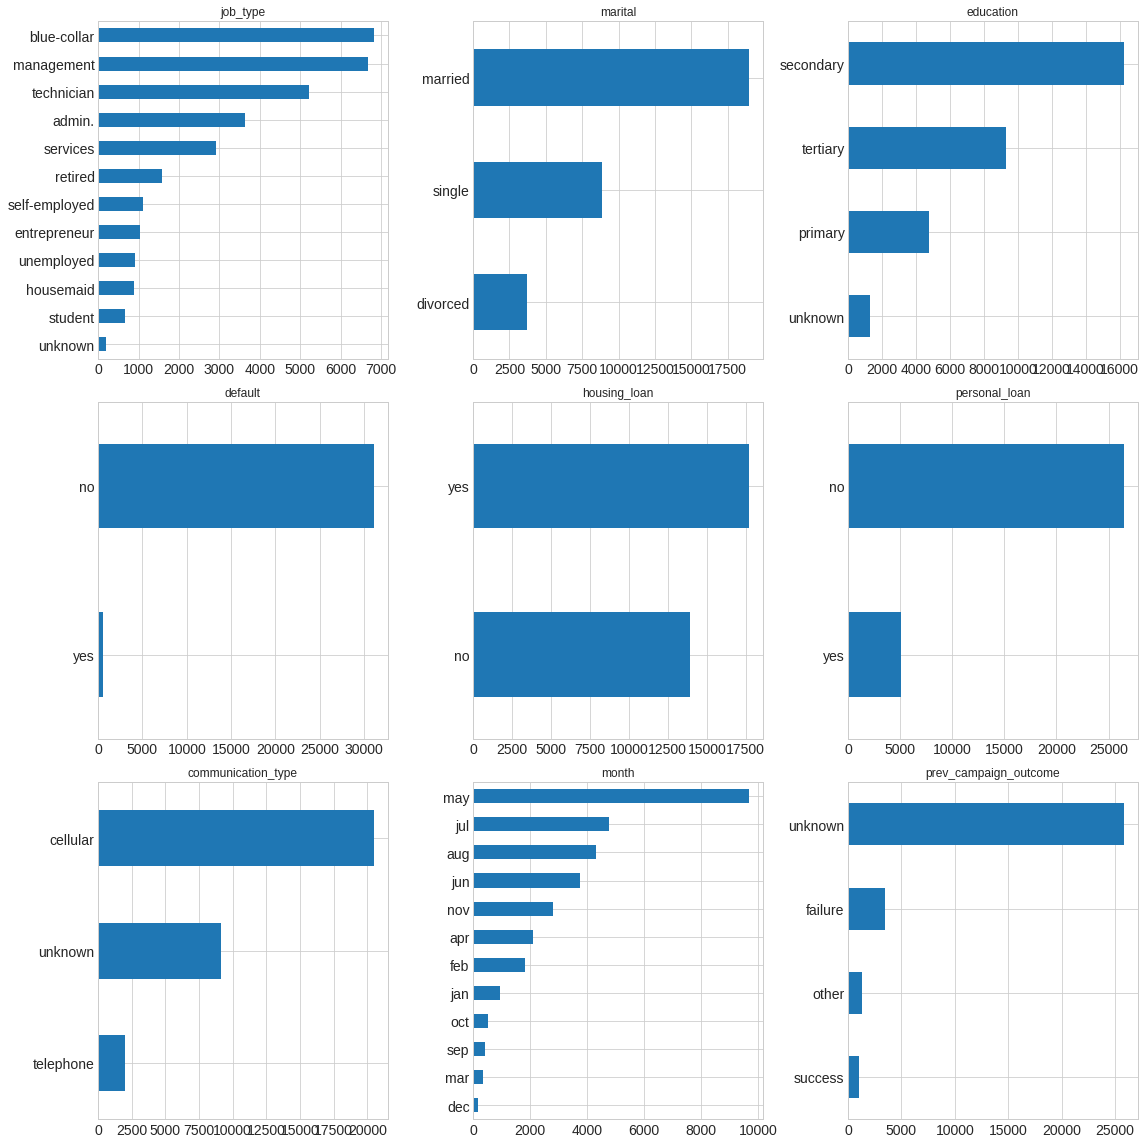

In [ ]:
fig, axes = plt.subplots(3, 3, figsize=(16, 16))
axes = [ax for axes_row in axes for ax in axes_row]

for i, c in enumerate(train[cat_cols]):
    _ = train[c].value_counts()[::-1].plot(kind = 'barh', ax=axes[i], title=c, fontsize=14)
    
_ = plt.tight_layout()

**Bivariate Analysis Relationships with Target**

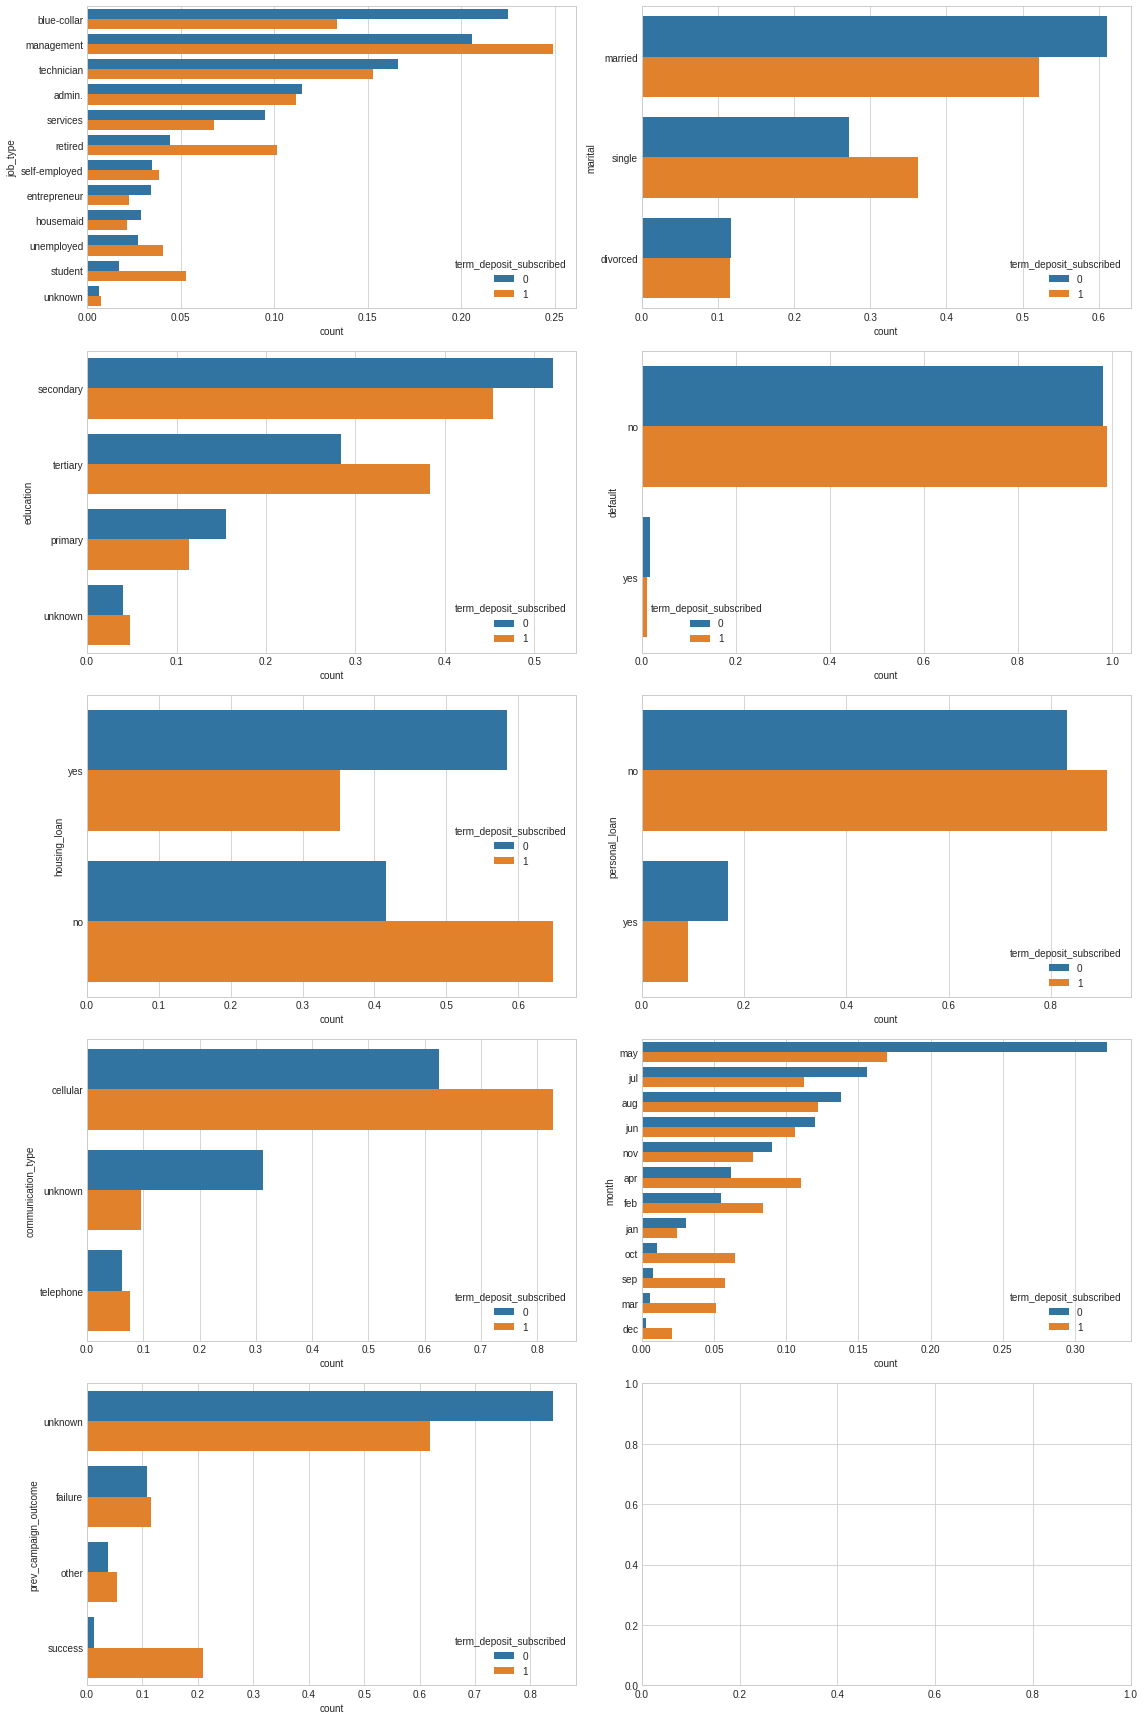

In [ ]:
fig, axes = plt.subplots(5, 2, figsize=(16, 24))
axes = [ax for axes_row in axes for ax in axes_row]

for i, c in enumerate(train[cat_cols]):
    fltr = train['term_deposit_subscribed'] == 0
    vc_a = train[fltr][c].value_counts(normalize=True).reset_index().rename({'index' : c, c: 'count'}, axis=1)

    vc_b = train[~fltr][c].value_counts(normalize=True).reset_index().rename({'index' : c, c: 'count'}, axis=1)

    vc_a['term_deposit_subscribed'] = 0
    vc_b['term_deposit_subscribed'] = 1

    df = pd.concat([vc_a, vc_b]).reset_index(drop = True)

    _ = sns.barplot(y = c, x = 'count', data =df , hue='term_deposit_subscribed', ax=axes[i])
    
_ = plt.tight_layout()

We can note things like, singles are taking more term deposits compared to married.
Most of the rejects were in May.
People with Management jobs subscribed more.
People not having housing loan are subscribing to term deposits. 

**Numeric variables EDA: Univariate**

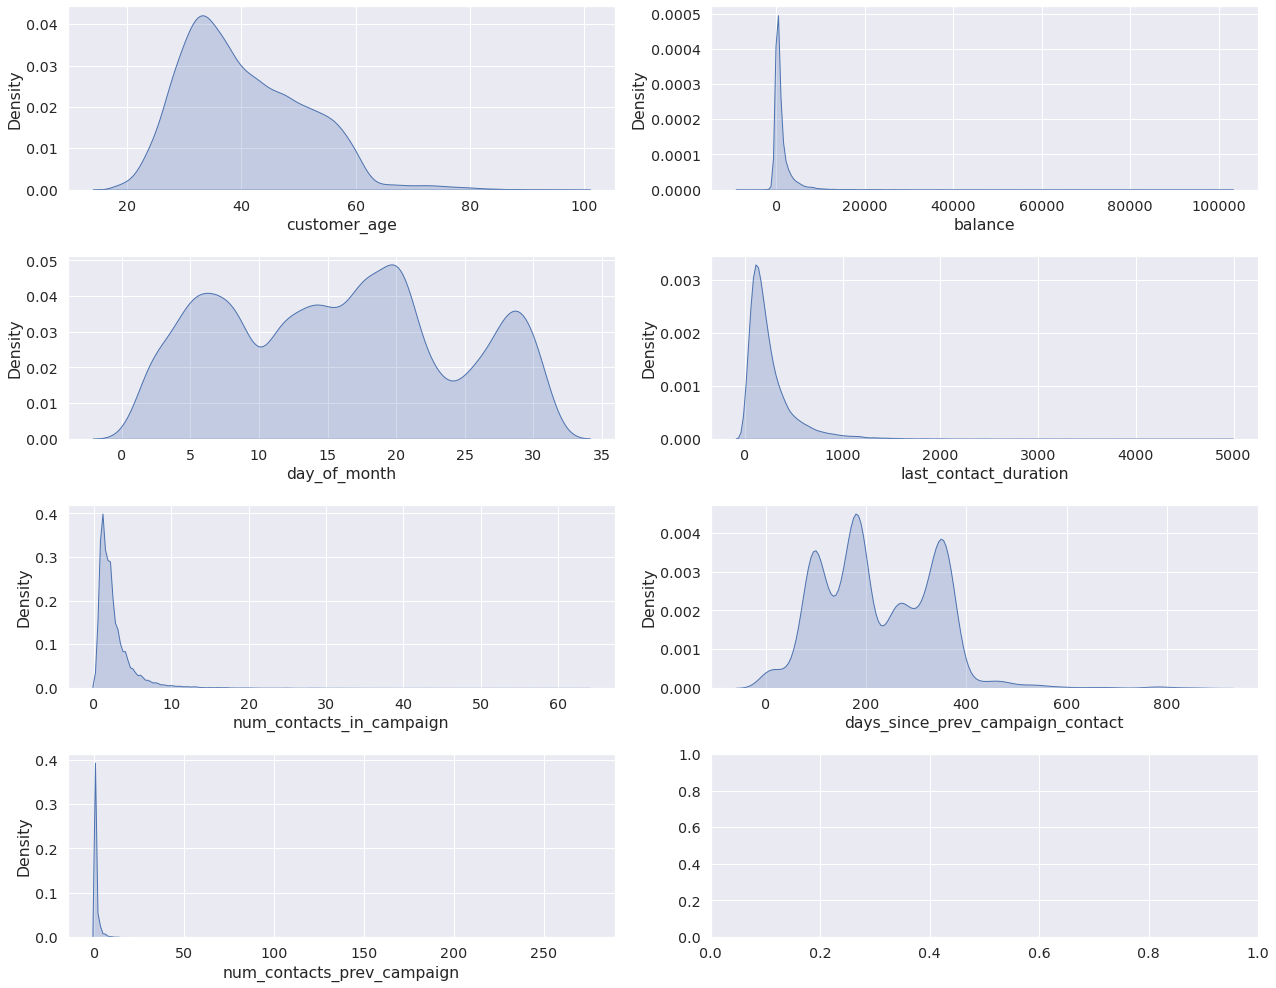

In [ ]:
sns.set(font_scale=1.3)
fig, axes = plt.subplots(4, 2, figsize=(18, 14))
axes = [ax for axes_row in axes for ax in axes_row]
for i, c in enumerate(num_cols):
  plot = sns.kdeplot(data=train, x=c, ax=axes[i], fill=True)
plt.tight_layout()

**Bivariate Analysis KDE plots - Relationships with Target**

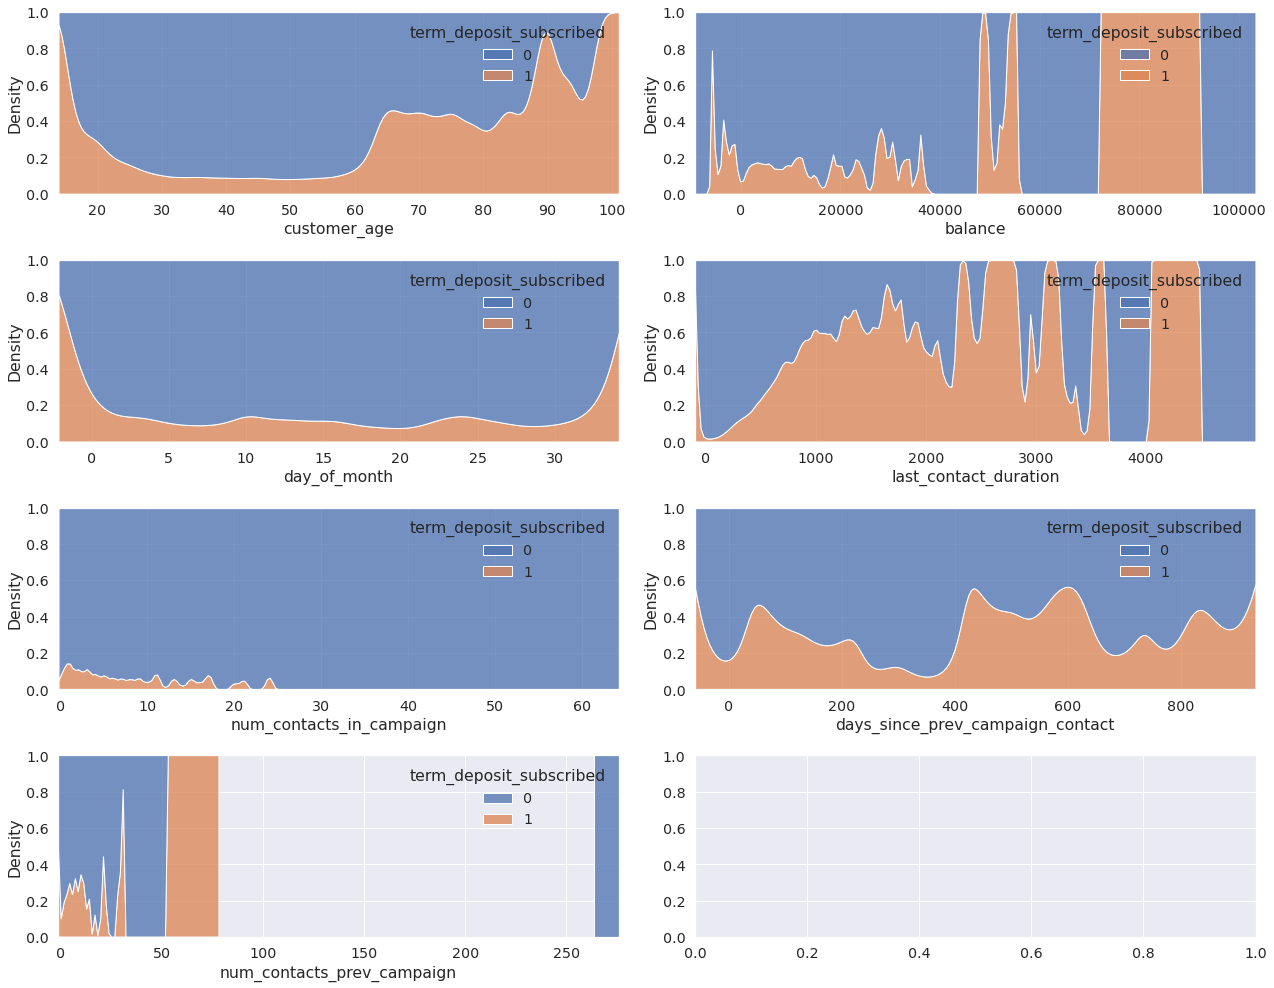

In [ ]:
sns.set(font_scale=1.3)
fig, axes = plt.subplots(4, 2, figsize=(18, 14))
axes = [ax for axes_row in axes for ax in axes_row]
for i, c in enumerate(num_cols):
  plot = sns.kdeplot(data=train, x=c, hue='term_deposit_subscribed', multiple='fill', ax=axes[i])
plt.tight_layout()

From 1st graph, we can see that, subscription rate is high for young and old customers.
From 2nd, people with high balance have high subscription rate
From 3rd, 1st and last day of the month have higher subscription, this might be because lot of people receive salary during this time.
From 4th, higher the duration, higher are the chances of subscription.
From 5th, higher number of calls does not mean high subcription.


**Bivariate Analysis - Horizontal BarPlots**
For each numerical variable, We will plot the median of the numerical variable for:

When term_deposit_subscribed == 0
when term_deposit_subscribed == 1
We are choosing median since median is not affected by outliers, and our data has a lot of outliers

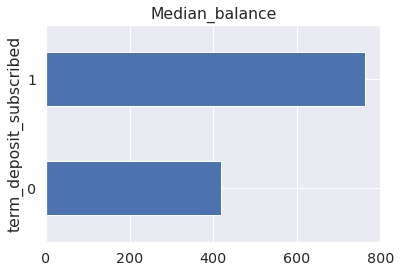

In [ ]:
_ = train.groupby('term_deposit_subscribed')['balance'].median().plot(kind = 'barh', title=f'Median_balance')

If you see the plot above median balance of customers not subscribing to a term deposit is around 400 whereas median balance of customers subscribing to a term deposit is 800. This definitely supports our initial hypothesis.

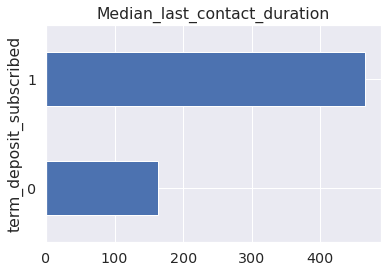

In [ ]:
_ = train.groupby('term_deposit_subscribed')['last_contact_duration'].median().plot(kind = 'barh', title=f'Median_last_contact_duration')

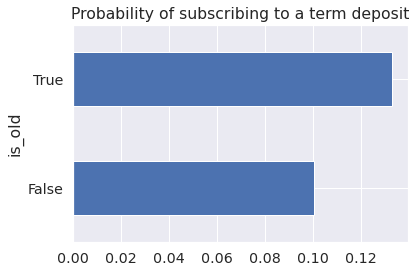

In [ ]:
train['is_old'] = True
train.loc[train['customer_age'] <= 50, 'is_old'] = False

_ = train.groupby('is_old')['term_deposit_subscribed'].mean().sort_values().plot(kind = 'barh', title='Probability of subscribing to a term deposit')

Looks like old age customers are definitely more likely to subscribe to a term deposit compared to younger age customers

**Bivariate Analysis - Correlation Heatmaps**

<Figure size 1008x576 with 0 Axes>

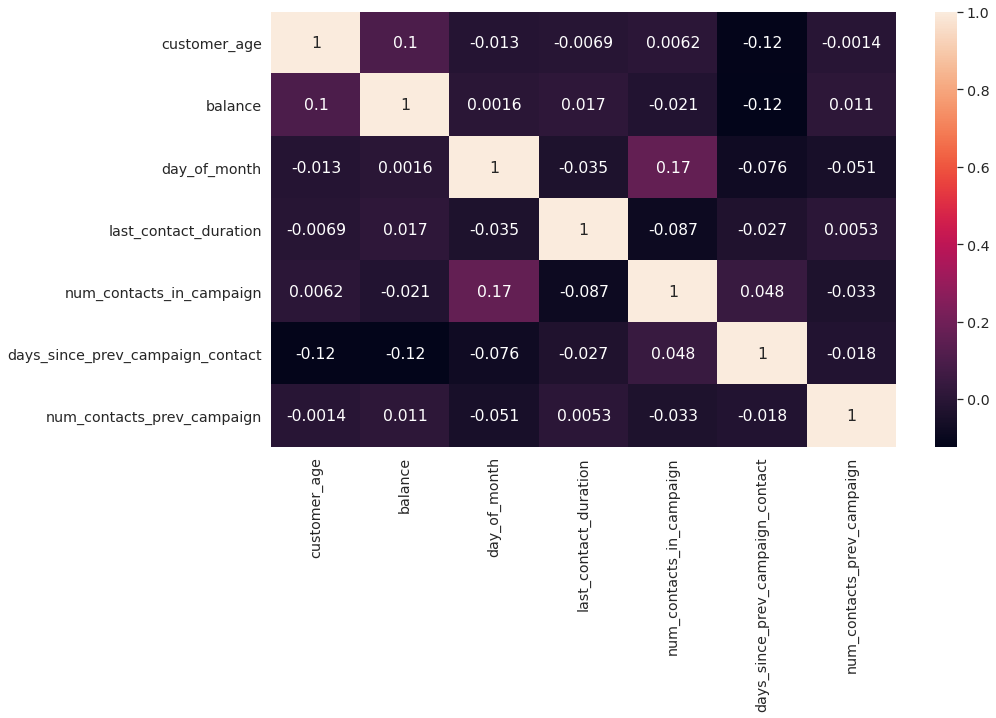

In [ ]:
plt.figure(figsize=(14, 8))
_ = sns.heatmap(train[num_cols].corr(), annot=True)